# Classiq coding competition -- Toffoli gate decomposition
> Based on the relative phase Toffoli gates
- toc: true 
- badges: true
- comments: true
- categories: [compilation, paper review]
- image: images/relative_toffoli.png

In [1]:
#collapse

try:
  import qiskit
except ImportError:
  !pip install qiskit
try:
  import pylatexenc
except ImportError:
  !pip install pylatexenc
  
from qiskit import transpile, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford, Operator, Statevector
from qiskit.extensions import UnitaryGate
from qiskit.circuit import Instruction
from typing import Union
import numpy as np

# What's in here?

I participated in [Classiq coding competition](https://www.classiq.io/competition) and submitted the second best solution to the [Toffoli](https://www.classiq.io/competition/toffoli) decomposition problem. The core technical trick to compress the resulting circuit was the use of the relative phase Toffoli gates, popularized by Dmitri Maslov in [this paper](https://arxiv.org/abs/1508.03273). 

In this post I will 
- briefly recap what are the Toffoli gates 
- introduce relative phase Toffoli gates 
- explain why are they useful
- illustrate by solving the Classiq problem

Amusingly, optimizing quantum circuits using an analog device (human brain) was exactly the kind of thing I wanted to avoid when I worked on the automatic compiler [CPFlow](https://arxiv.org/abs/2205.01121). However, our compiler works well only with small circuits, to solve a larger problem one needs to decompose it into digestible pieces. In the end, I found no efficient way to use the computer search in the original problem, but came up with paper-and-pencil solution. The usefulness of the relative phase Toffoli gates, which I will cover in some depth here, of course extends far beyond.

# Toffoli gates

## CNOT

The simplest "Toffoli" gate is CNOT gate, also known as controlled NOT or controlled X (CX). 

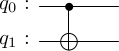

In [2]:
#collapse
qc = QuantumCircuit(2)
qc.cx(0,1)

# Note, if you draw this interactively and have an error here (happens in Colab), redefine the global variable below.
# output = 'mpl'

qc.draw(output=output)

It flips the value (applies X gate) of the second qubit if the first qubit is in state $|1\rangle$ and does nothing if the first qubit is in state $|0\rangle$. The first qubit is called the _control_ qubit, the last is called the _target_. If the target qubit starts in state $|0\rangle$, than CNOT effectively copies that value of the control qubit to the target.

## 3q Toffoli

The regular Toffoli gates is defined on three qubits.

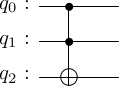

In [3]:
#collapse
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.draw(output=output)

It has two controls and one target. This gate flips the value of the target qubit if and only if both of the control qubits are in state $|1\rangle$, and does nothing otherwise. If the target qubit starts in state $|0\rangle$ the Toffoli gate effectively stores the logical AND of the control qubits $q_0 \land q_1$ in the target register.

## n-qubit Toffoli

This construction has a plain generalization to multiple control qubits, e.g. here is the the Toffoli gate on 5 qubits (with 4 control qubits)

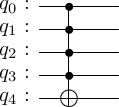

In [4]:
#collapse
qc = QuantumCircuit(5)
qc.mct([0, 1, 2, 3], 4)
qc.draw(output=output)

$n-$qubit Toffoli gates are very important primitives in quantum computing. For elaboration on this claim I recommend the introduction section in [Maslov's paper](https://arxiv.org/abs/1508.03273), which starts with

_"Multiple control Toffoli gates are the staple of quantum arithmetic and reversible circuits.  They are employed widely within quantum algorithms, including inreversible transformations, such as arithmetic circuits and all sorts of Boolean operations over quantum registers, as well as subroutines within other specialized quantum transforms."_

## Decompositions

Although there are intriguing recent suggestions to implement multiple-control Toffoli gates directly (see e.g. [here](https://arxiv.org/abs/2006.07035)) most hardware platforms currently require them to be decomposed into 1q+2q gates. This is the same what the Classiq problem asked for, to decompose a multiple-controlled Toffoli gate into CNOT gates and arbitrary 1q gates.

I will denote Toffoli gates on $n$ qubits (with $n-1$ controls) by $T^n$ (another frequent notation is $C^{n-1}X$). $T^2$ gate, which is just CNOT, need no further decomposition. $T^3$ gate, the regular Toffoli gate, can be decomposed into CNOT+1q gates as follows.

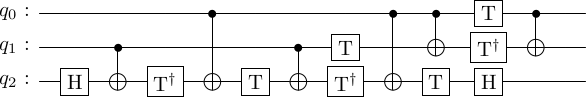

In [5]:
#collapse
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
qc.decompose().draw(output=output)

This decomposition has 6 CNOT gates as well as depth 6 with respect to CNOT gates. Total depth is 11. We will be looking for similar decompositions of $T^{n}$ with $n\ge3$. The goal of the Classiq challenge was to find decompositions with the smallest total depth. Other optimization metrics such as CNOT count, CNOT depth or T count and T depth may be preferred for some applications. Here T without a superscript refers to the magic [T gates](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TGate.html), which are important for fault-tolerant circuits. Fortunately, these metrics are not that much decoupled, and a circuit efficient in one respect is also often very efficient in others, see again Maslov's [paper](https://arxiv.org/abs/1508.03273) for examples.

## Ancilla qubits

As CNOT+1q gates set is universal, it can be used to decompose an arbitrary $n-$qubit gate, including $T^n$. The efficiency of this decomposition can be greatly enhanced if ancilla qubits are provided. Here is an example using a clean ancilla qubit to decompose $T^4$ into three regular Toffoli gates.

<img src="myimages/toffoli/T4/T4.png" alt="Drawing" style="width: 250px;"/>

The first $T^3$ stores $q_0 \land q_1$ in the ancilla qubit. The second $T^3$ combines this with an additional control and applies to the target. The last step is called _uncomputation_, it is only to restore the state of the ancilla bit to $|0\rangle$ ($T^3$ applied twice is the identity). For a great introduction covering Toffoli gates, their decompositions, various type of ancilla qubits and more see this [blog series](https://algassert.com/circuits/2015/06/05/Constructing-Large-Controlled-Nots.html) by Craig Gidney. 


As constructed, the circuit for $T^4$ with one clean ancilla uses three $T^3$ and has CNOT count $3\times6=18$. I will now show how this can be compressed using relative phase Toffoli gates.

<img src="myimages/toffoli/relative_toffoli.png" alt="Drawing" style="width: 600px;"/>
(The wiggly lines are to emphasize the wave nature of quantum mechanics. Seriously though, the words 'relative phase' remind me of the phase shifts in signal processing, and I had to come up with some pic for this post anyway.)

# Relative phase Toffoli gates

## Definition

Relative phase Toffoli gates $RT^n$ are defined as standard Toffoli gates $T^n$ followed by a diagonal gate $D^n$. I will draw them as follows.

<img src="myimages/toffoli/RT3/RT3.png" alt="Drawing" style="width: 400px;"/>

So, the boxed Toffoli gate stands for the relative phase Toffoli gate. The boxed controlled Z gate (last gate on the right circuit) will be my notation for the diagonal gate itself. Note that this representation is not standard (which I found difficult to typeset), my apologies.

## Diagonal gates

Diagonal gate is just what it sounds, a gate with only diagonal entries. For instance, a general 2q diagonal gate gate be written as $D=e^{\phi_0}|00\rangle\langle00|+e^{\phi_1}|01\rangle\langle01|+e^{\phi_2}|10\rangle\langle10|+e^{\phi_3}|11\rangle\langle11|$. The relative phase Toffoli gate is called that way because its elements only differ from the original Toffoli gate by a phase. Crucially, different elements may differ by different phases (so this is not the irrelevant global phase). Diagonal gates themselves are non-trivial objects. For example, up to a conjugation by two Hadamard gates $n-$qubit Toffoli gate is equivalent to $n-$qubit controlled Z gate, which is diagonal.

## Relative gates are shorter

Why care about the relative phase gates? First, they can have shorter representations compared to the original gates. This might look unreasonable at first, because we are _adding_ an extra diagonal gate. However, the extra gate can _cancel_ part of the original circuit. So, by appending a suitable diagonal gate one can make the relative phase Toffoli gate _shorter_ than the Toffoli gate itself. Here is an example of $RT^3$ gate.

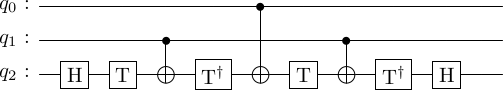

In [6]:
#collapse
# Build circuit
qc = QuantumCircuit(3)
qc.h(2)
qc.t(2)
qc.cx(1, 2)
qc.tdg(2)
qc.cx(0, 2)
qc.t(2)
qc.cx(1, 2)
qc.tdg(2)
qc.h(2)

# Store to gate
RT3 = qc.to_instruction(label='RT3')
RT3dg = RT3.inverse()
RT3dg.label = 'RT3dg'

# Draw
qc.draw(output=output)

Note that it only has 3 CNOT gates, while $T^3$ requires 6 gates. Here is a numeric way to check that this gate is indeed $RT^3$.

In [7]:
def is_relative(U, V):
    D = V.conj().T @ U
    # If and only if D is unitary and diagonal the check is True.
    check = np.allclose(np.abs(D), np.eye(U.shape[0])) 
    return check

# Check that it is indeed the relative phase Toffoli 3 gate
u_RT3 = Operator(qc).data
qc_T3 = QuantumCircuit(3)
qc_T3.ccx(0, 1, 2)
u_T3 = Operator(qc_T3).data # Regular Toffoli gate.
print('is RT3:', is_relative(u_RT3, u_T3))

is RT3: True


## Diagonal gates commute with controls

Second, the relative phase Toffoli gates can be used instead of the standard Toffoli gates in compute-uncompute pairs. For example, $T^4$ with one clean ancilla can be decomposed in the following way.

<img src="myimages/toffoli/T4_with_RT3/T4_with_RT3.png" alt="Drawing" style="width: 250px;"/>

Here the second relative gate should be $(RT^3)^\dagger$ but I leave it implicit in the notation.
OK, but why can we replace $T^3$ by $RT^3$? Because a diagonal gate commutes with a control.

<img src="myimages/toffoli/D_commute/D_commute.png" alt="Drawing" style="width: 400px;"/>

Wires with backslash on them denote a group of several qubits. $U$ can be any operator on $n$ qubits. The diagonal gate can also act on any number of qubits $k+m$. And they can intersect along any number of controls $m$. To show this in full generality would be a bit of a notational mess. Here is the idea though. General diagonal gate can be represented as $D=\sum_n P_n e^{i\phi_n}$ where $P_n=|n\rangle\langle n|$ is the projector on $n-$th basis state. General controlled unitary is $CU = P_0\otimes I+P_1\otimes U$. The matrix $U$ is only applied to the qubits that are not touched by the diagonal gate, therfore $D$ and $CU$ only intersect along wires containing projectors. Since projectors commute, the whole operators also commute. Here is an illustration for the 2q D and $n$-qubit U

$$\Big[\Big(e^{\phi_0}|00\rangle\langle00|+e^{\phi_1}|01\rangle\langle01|+e^{\phi_2}|10\rangle\langle10|+e^{\phi_3}|11\rangle\langle11|\Big)\otimes I_{n+1}, I_1\otimes |0\rangle\langle0|\otimes I_{n}+I_1\otimes |0\rangle\langle0|\otimes U_n\Big]=0$$

Since $RT^3$ contains 3 CNOT gates the new construction for $T^4$ now has only 12 CNOT gates, significantly improving on the preceding 18 CNOT decomposition. 

## Special relative phase gates

Here is another version of $RT^3$, known as a _special_ relative phase Toffoli gate $SRT^3$. 

is relative: True


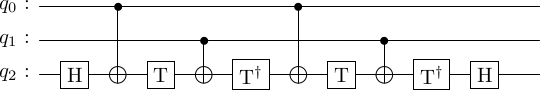

In [8]:
#collapse
# Similar to the privious circuit but with an additional CZ gate
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(0, 2)
qc.h(2)
qc.append(RT3, [0, 1, 2])
qc = qc.decompose('RT3')
qc = transpile(qc, basis_gates=['cx', 't', 'tdg', 'h'], optimization_level=3)
qc.draw(output='mpl')

# Store to gate
SRT3 = qc.to_instruction(label='SRT3')
SRT3dg = qc.inverse().to_instruction(label='SRT3dg')

# Check that it is indeed the relative phase Toffoli 3 gate
u_SRT3 = Operator(qc).data
print('is relative:', is_relative(u_SRT3, u_T3))

# Draw
qc.draw(output=output)

This circuit has one more CNOT gate than $RT^3$ defined above. A special feature of this gate (and the reason it is called special) is that the diagonal gate has a restricted form -- it only acts on the first two qubits, graphically

<img src="myimages/toffoli/SRT3/SRT3.png" alt="Drawing" style="width: 400px;"/>

## $RT^4$

As suggested by Maslov, this gate can be used to construct $RT^4$ out of $RT^3$. Indeed, take a look at the following circuit.

<img src="myimages/toffoli/RT4/RT4.png" alt="Drawing" style="width: 500px;"/>

It is obtained from $RT^3$ by adding an extra qubit and replacing the middle CNOT with $SRT^3$. Why does this work? The new circuit must (1) do what the 3q circuit did when the state of $q_0$ is $|1\rangle$ and (2) do nothing if the state of $q_0$ is $|0\rangle$.  When the new qubit is in state $|1\rangle$, the $RT^3$ gate behaves just like a CNOT between $q_1$ and $q_3$ and we are back to the 3q circuit behavior. When the new qubit is $|0\rangle$, the $RT^3$ gate becomes 3q identity, and all gates around it cancel in pairs, so the whole circuit is 4q identity. Good. Finally, the additional diagonal gate acting on $q_0, q_1$ can be moved to the right and combined with the diagonal gate defining $RT^3$. Note that if we inserted $RT^3$ instead of $SRT^3$ in the middle, this wouldn't work because 3q diagonal gate would not commute with gates on qubit $q_3$. This implementation of $RT^4$ has 6 CNOT gates, which is apparently the optimal result.

Here is an explicit implementation.

is relative: True


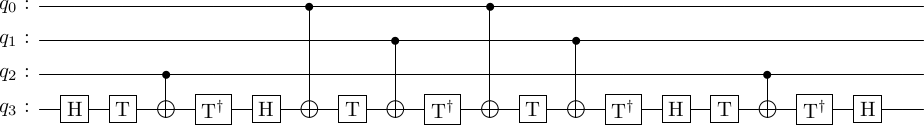

In [9]:
#collapse
# Build circuit
qc = QuantumCircuit(4)
qc.h(3)
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.append(SRT3, [0, 1, 3])
qc.t(3)
qc.cx(2, 3)
qc.tdg(3)
qc.h(3)
qc = qc.decompose('SRT3')

# Store to gate
RT4 = qc.to_instruction(label='RT4')
RT4dg = RT4.inverse()
RT4dg.label = 'RT4dg'

# Check that it is indeed the relative phase Toffoli 3 gate
u_RT4 = Operator(qc).data
qc_T4 = QuantumCircuit(4)
qc_T4.mct([0, 1, 2], 3)
u_T4 = Operator(qc_T4).data
print('is relative:', is_relative(u_RT4, u_T4))

# Draw
qc.draw(output=output)

## $RT^5$

The final ingredient I will need is $RT^5$. It is not present in Maslov's paper and I haven't found it with a brief search in other literature, but we can use the same idea to build $RT^5$ out of $RT^4$ and $SRT^3$. Namely, in the diagram above we replace both CNOTs acting between $q_0$ and $q_3$ by $SRT^3$. This leads to the following circuit.

is relative: True


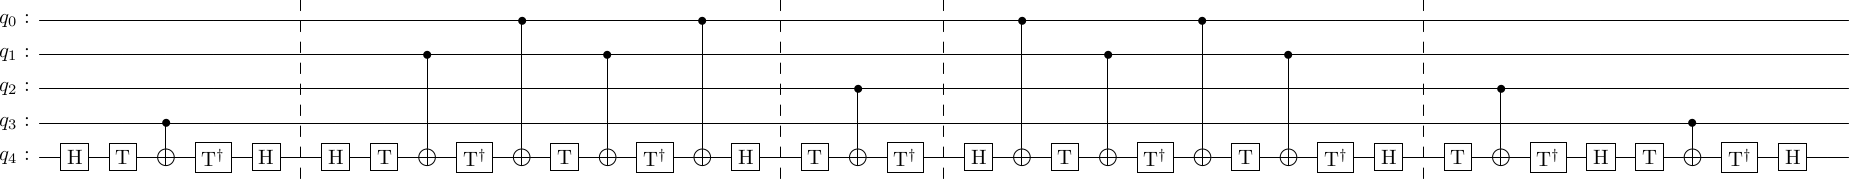

In [10]:
#collapse
# Build circuit
qc = QuantumCircuit(5)
qc.h(4)
qc.t(4)
qc.cx(3, 4)
qc.tdg(4)
qc.h(4)
qc.barrier()
qc.append(SRT3dg, [0, 1, 4])
qc.barrier()
qc.t(4)
qc.cx(2, 4)
qc.tdg(4)
qc.barrier()
qc.append(SRT3, [0, 1, 4])
qc.barrier()
qc.t(4)
qc.cx(2, 4)
qc.tdg(4)
qc.h(4)
qc.t(4)
qc.cx(3, 4)
qc.tdg(4)
qc.h(4)

qc = qc.decompose('RT3')
qc = transpile(qc, basis_gates=['cx', 't', 'tdg', 'h'], optimization_level=3)

# Check that it is indeed the relative phase Toffoli 3 gate
u_RT5 = Operator(qc).data
qc_T5 = QuantumCircuit(5)
qc_T5.mct([0, 1, 2, 3], 4)
u_T5 = Operator(qc_T5).data
print('is relative:', is_relative(u_RT5, u_T5))

# Draw
qc.draw(output=output)

Subcircuits between barriers are the inserted $SRT^3$ gates. This circuit has 12 CNOT gates. Apparently, by looking at it carefully enough one can find a pair of CNOT gates that cancel each other. I stumbled upon this fact by accident. I tried to substitute shorter $RT^3$ instead of $SRT^3$ here and was sure it would fail, but it worked. The resulting decomposition of $RT^5$ has only 10 CNOT gates. Here is the circuit.

is relative: True


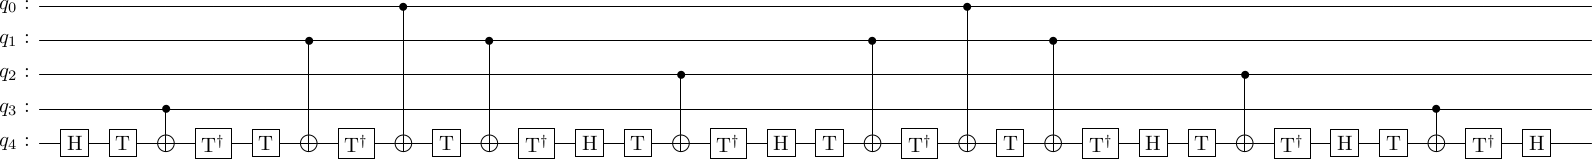

In [11]:
#collapse
# Build circuit
qc = QuantumCircuit(5)
qc.h(4)
qc.t(4)
qc.cx(3, 4)
qc.tdg(4)
qc.h(4)
qc.append(RT3, [0, 1, 4])
qc.t(4)
qc.cx(2, 4)
qc.tdg(4)
qc.append(RT3, [0, 1, 4])
qc.t(4)
qc.cx(2, 4)
qc.tdg(4)
qc.h(4)
qc.t(4)
qc.cx(3, 4)
qc.tdg(4)
qc.h(4)

qc = qc.decompose('RT3')
qc = transpile(qc, basis_gates=['cx', 't', 'tdg', 'h'], optimization_level=3)

# Store to gate
RT5 = qc.to_instruction(label='RT5')
RT5dg = RT5.inverse()
RT5dg.label = 'RT5dg'


# Check that it is indeed the relative phase Toffoli 3 gate
u_RT5 = Operator(qc).data
qc_T5 = QuantumCircuit(5)
qc_T5.mct([0, 1, 2, 3], 4)
u_T5 = Operator(qc_T5).data
print('is relative:', is_relative(u_RT5, u_T5))

# Draw
qc.draw(output=output)

## Generalization of relative phase gates

It is possible to further generalize relative phase gates by allowing more general operators which cancel in compute-uncompute pairs. See Maslov's paper for the use of more general gates with dirty ancilla qubits.

# Solution to the Classiq problem

Now all of the ingredients are in place. The original problem statement is [here](https://www.classiq.io/competition/toffoli). One needs to decompose a Toffoli gate with 14 controls and one target using no more than 5 clean ancilla qubits, 20 qubits in total. The ancilla must be returned into original state. Best solution is the one with the smallest depth. Here is my solution.

<img src="myimages/toffoli/T15/T15.png" alt="Drawing" style="width: 300px;"/>

The intuition is a follows. Having the smallest depth means that we need to perform as many operations in parallel as possible. The first layer in the circuit divides the 14 control qubits into four groups $14=4+4+3+3$, and stores their logical ANDs in four of the available ancilla qubits. It remains to compute the logical AND of these four ancilla and write it to the target qubit, i.e. to perform $T^5$ gate. To make this operation efficient we have one more clean ancilla available. Layers 2, 3 and 4 thus perform $T^5$ gate with the use of the last clean ancilla. The very last layer uncomputes the first. This circuit works if all of the gates used are plain Toffoli gates. However, using relative phase Toffoli gates in compute-uncompute pairs significantly reduces the depth.

The expected CNOT depth is $38=2\times 10+2\times 6+6$, where $10$ is the depth of $RT^5$, 6 of $RT^4$ and the last 6 is the depth of $T^3$. The 1q depth should be about twice as much. Note that by the rules of the competition general single-qubit gates can be used, which means that, say, $H$ and $T$ gates can be combined together and count as a single gate.


After using `qiskit` transpiler the final CNOT and total depth of the circuit are a bit smaller than estimated above. I am not sure where the optimization comes from, but many thanks to the transpiler! Here is a complete solution coded in `qiskit`.

In [12]:
#collapse
c41 = QuantumRegister(4, 'c41')
c42 = QuantumRegister(4, 'c42')
c31 = QuantumRegister(3, 'c31')
c32 = QuantumRegister(3, 'c32')

a = [QuantumRegister(1, f'a{i}') for i in range(1, 6)]
t = QuantumRegister(1, 'trgt')

qc = QuantumCircuit(c41, a[0], c42, a[1], c31, a[2], c32, a[3], a[4], t)

qc.append(RT5, list(range(0, 5)))
qc.append(RT5, list(range(5, 10)))
qc.append(RT4, list(range(10, 14)))
qc.append(RT4, list(range(14, 18)))

qc.append(RT4, [4, 9, 13, 18])
qc.ccx(17, 18, 19)
qc.append(RT4dg, [4, 9, 13, 18])

qc.append(RT5dg, list(range(0, 5)))
qc.append(RT5dg, list(range(5, 10)))
qc.append(RT4dg, list(range(10, 14)))
qc.append(RT4dg, list(range(14, 18)))

qc.draw()

┌──────┐                       ┌────────┐
c41_0: ┤0     ├───────────────────────┤0       ├
       │      │                       │        │
c41_1: ┤1     ├───────────────────────┤1       ├
       │      │                       │        │
c41_2: ┤2 RT5 ├───────────────────────┤2 RT5dg ├
       │      │                       │        │
c41_3: ┤3     ├───────────────────────┤3       ├
       │      │┌──────┐     ┌────────┐│        │
   a1: ┤4     ├┤0     ├─────┤0       ├┤4       ├
       ├──────┤│      │     │        │├────────┤
c42_0: ┤0     ├┤      ├─────┤        ├┤0       ├
       │      ││      │     │        ││        │
c42_1: ┤1     ├┤      ├─────┤        ├┤1       ├
       │      ││      │     │        ││        │
c42_2: ┤2 RT5 ├┤      ├─────┤        ├┤2 RT5dg ├
       │      ││      │     │        ││        │
c42_3: ┤3     ├┤      ├─────┤        ├┤3       ├
       │      ││      │     │        ││        │
   a2: ┤4     ├┤1     ├─────┤1       ├┤4       ├
       ├──────┤│      │     │        │├────────┤
c31_0: ┤0     ├┤      ├─────┤        ├┤0       ├
       │      ││      │     │        ││        │
c31_1: ┤1     ├┤  RT4 ├─────┤  RT4dg ├┤1       ├
       │  RT4 ││      │     │        ││  RT4dg │
c31_2: ┤2     ├┤      ├─────┤        ├┤2       ├
       │      ││      │     │        ││        │
   a3: ┤3     ├┤2     ├─────┤2       ├┤3       ├
       ├──────┤│      │     │        │├────────┤
c32_0: ┤0     ├┤      ├─────┤        ├┤0       ├
       │      ││      │     │        ││        │
c32_1: ┤1     ├┤      ├─────┤        ├┤1       ├
       │  RT4 ││      │     │        ││  RT4dg │
c32_2: ┤2     ├┤      ├─────┤        ├┤2       ├
       │      ││      │     │        ││        │
   a4: ┤3     ├┤      ├──■──┤        ├┤3       ├
       └──────┘│      │  │  │        │└────────┘
   a5: ────────┤3     ├──■──┤3       ├──────────
               └──────┘┌─┴─┐└────────┘          
 trgt: ────────────────┤ X ├────────────────────
                       └───┘

The CNOT and overall depth of the circuit can be computed as follows.

In [13]:
qc_final = transpile(qc, basis_gates=['cx', 'u'])

print('total depth:', qc_final.depth())
print('CX depth:', qc_final.depth(lambda gate: gate[0].name == 'cx'))

total depth: 70
CX depth: 36


It is of course possible to use other ways of splitting the control qubits into groups and/or using the ancilla qubits differently. I'm really curious to look at solutions submitted by other participants, including the best one due to Soshun Naito. Looking forward to Classiq announcement!

___Update___: As noted by [Alexander Gramolin](https://www.linkedin.com/in/gramolin/), this decomposition can be improved by using an upgraded version of the Toffoli 3 gate sitting in the middle of the circuit. My implementation above uses standard `qiskit` decomposition with depth 11. A better option is to use depth-8 Toffoli gate from [this paper](https://arxiv.org/abs/1206.0758) (be sure Dmitri Maslov if one of the authors:):

is T3: True


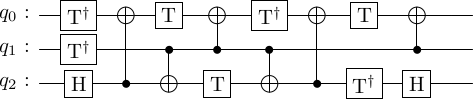

In [14]:
#collapse
# Build circuit
qc = QuantumCircuit(3)
qc.tdg(0)
qc.tdg(1)
qc.h(2)
qc.cx(2, 0)
qc.t(0)
qc.cx(1, 2)
qc.cx(1, 0)
qc.t(2)
qc.tdg(0)
qc.cx(1, 2)
qc.cx(2, 0)
qc.t(0)
qc.tdg(2)
qc.cx(1, 0)
qc.h(2)

# Store to gate
T3 = qc.to_instruction(label='T3')

# Check that it is indeed the relative phase Toffoli 3 gate
u_T3 = Operator(qc).data
qc_T3_standard = QuantumCircuit(3)
qc_T3_standard.ccx(0, 1, 2)
u_T3_standard = Operator(qc_T3_standard).data
print('is T3:', np.allclose(u_T3, u_T3_standard))

# Draw
qc.draw(output=output)

This reduces $CX$ depth by 1 and total depth by 4!

In [15]:
#collapse
c41 = QuantumRegister(4, 'c41')
c42 = QuantumRegister(4, 'c42')
c31 = QuantumRegister(3, 'c31')
c32 = QuantumRegister(3, 'c32')

a = [QuantumRegister(1, f'a{i}') for i in range(1, 6)]
t = QuantumRegister(1, 'trgt')

qc = QuantumCircuit(c41, a[0], c42, a[1], c31, a[2], c32, a[3], a[4], t)

qc.append(RT5, list(range(0, 5)))
qc.append(RT5, list(range(5, 10)))
qc.append(RT4, list(range(10, 14)))
qc.append(RT4, list(range(14, 18)))

qc.append(RT4, [4, 9, 13, 18])
qc.append(T3, [17, 18, 19])
qc.append(RT4dg, [4, 9, 13, 18])

qc.append(RT5dg, list(range(0, 5)))
qc.append(RT5dg, list(range(5, 10)))
qc.append(RT4dg, list(range(10, 14)))
qc.append(RT4dg, list(range(14, 18)))

qc_final = transpile(qc, basis_gates=['cx', 'u'])

print('total depth:', qc_final.depth())
print('CX depth:', qc_final.depth(lambda gate: gate[0].name == 'cx'))

total depth: 66
CX depth: 35
